In [17]:
import os
import copy

from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
import tqdm

from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Data loading

In [2]:
data_dir = Path("..") / "data"
data_dir

PosixPath('../data')

In [3]:
data_paths = glob(str(data_dir) + os.sep + "*.csv")
data_paths

['../data/BTCUSDT-1h-2023-05.csv',
 '../data/BTCUSDT-1h-2023-04.csv',
 '../data/BTCUSDT-1h-2023-03.csv',
 '../data/BTCUSDT-1h-2023-02.csv',
 '../data/BTCUSDT-1h-2023-01.csv']

In [4]:
dfs = []
for path in data_paths:
    dfs.append(pd.read_csv(path))

df = pd.concat(dfs, ignore_index=True)
df.head()

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
0,1682899200000,29233.20,29337.34,29215.93,29315.57,1884.84043,1682902799999,5.520089e+07,43324,898.64952,2.631818e+07,0
1,1682902800000,29315.57,29315.57,28369.95,28504.36,7975.68782,1682906399999,2.293187e+08,138973,3628.42240,1.042351e+08,0
2,1682906400000,28504.36,28680.38,28414.00,28549.41,4047.55713,1682909999999,1.157070e+08,80081,1951.63029,5.578657e+07,0
3,1682910000000,28549.42,28592.95,28436.27,28561.06,2058.76530,1682913599999,5.874546e+07,39032,985.69333,2.812657e+07,0
4,1682913600000,28561.07,28589.84,28486.29,28555.00,1378.42285,1682917199999,3.933649e+07,27790,632.14694,1.803986e+07,0


In [5]:
df.describe()

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
count,3.623000e+03,3623.000000,3623.000000,3623.000000,3623.000000,3623.000000,3.623000e+03,3.623000e+03,3.623000e+03,3623.000000,3.623000e+03,3623.0
mean,1.679052e+12,24952.512250,25037.069782,24866.591609,24955.465156,8022.262092,1.679056e+12,1.877299e+08,1.994754e+05,3998.883325,9.359411e+07,0.0
std,3.767197e+09,3631.356695,3643.949958,3616.074695,3628.861353,8658.526405,3.767197e+09,2.012761e+08,1.901867e+05,4342.665353,1.010701e+08,0.0
min,1.672531e+12,16513.330000,16534.030000,16499.010000,16513.340000,0.000000,1.672535e+12,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0
25%,1.675791e+12,22668.710000,22745.775000,22564.705000,22673.565000,1738.100850,1.675795e+12,4.860116e+07,3.908750e+04,858.773440,2.413729e+07,0.0
50%,1.679051e+12,26131.270000,26267.290000,25993.280000,26142.140000,5633.435750,1.679054e+12,1.265667e+08,1.558990e+05,2819.416980,6.278053e+07,0.0
75%,1.682314e+12,27914.255000,28013.285000,27841.235000,27914.255000,10896.039840,1.682318e+12,2.460295e+08,3.057140e+05,5421.462915,1.223110e+08,0.0
max,1.685574e+12,30942.860000,31000.000000,30758.890000,30942.870000,80041.752040,1.685578e+12,2.019041e+09,1.442097e+06,41799.705160,1.054693e+09,0.0


## Data preparation

In [6]:
# standardization
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df.values)
df_ = pd.DataFrame(x_scaled, columns=df.columns)
df_ = df_[["open", "high", "low", "close", "volume"]]
df_.head()

,open,high,low,close,volume
0,0.881517,0.885064,0.891797,0.887224,0.023548
1,0.887225,0.883559,0.832471,0.831006,0.099644
2,0.831006,0.839650,0.835560,0.834128,0.050568
3,0.834129,0.833606,0.837122,0.834935,0.025721
4,0.834936,0.833391,0.840630,0.834515,0.017221


In [7]:
# history
def mk_history(dataframe: pd.DataFrame, window_size: int = 3):
    
    def to_list_or_na(w, length: int):
        res = w.to_list()
        if len(res) != length:
            return None
        return res
    
    for col in dataframe.columns:
        dataframe[f"w_{col}"] = [to_list_or_na(window, length=3) for window in dataframe[col].rolling(window=window_size, closed="left")]
        
    dataframe = dataframe.dropna()
    x_cols = [col for col in dataframe.columns if col.startswith("w_")]
    dataframe = dataframe[x_cols + ["close"]]
    dataframe["x"] = dataframe[x_cols].apply(lambda row: [item for sublist in row for item in sublist], axis=1)
    return dataframe

df_ = mk_history(df_)
df_.head()

,w_open,w_high,w_low,w_close,w_volume,close,x
3,"[0.8815165843932549, 0.8872250170310465, 0.831...","[0.8850640503194738, 0.8835591391382671, 0.839...","[0.8917971259225186, 0.8324712409922106, 0.835...","[0.8872243240077811, 0.83100558368845, 0.83412...","[0.02354821554953059, 0.09964409344780753, 0.0...",0.834935,"[0.8815165843932549, 0.8872250170310465, 0.831..."
4,"[0.8872250170310465, 0.8310062767117155, 0.834...","[0.8835591391382671, 0.8396498817569789, 0.833...","[0.8324712409922106, 0.835560327295882, 0.8371...","[0.83100558368845, 0.8341276534994557, 0.83493...","[0.09964409344780753, 0.050568072622614216, 0....",0.834515,"[0.8872250170310465, 0.8310062767117155, 0.834..."
5,"[0.8310062767117155, 0.8341290395459864, 0.834...","[0.8396498817569789, 0.833606042318628, 0.8333...","[0.835560327295882, 0.8371220515179651, 0.8406...","[0.8341276534994557, 0.8349350256037447, 0.834...","[0.050568072622614216, 0.02572114237293499, 0....",0.829572,"[0.8310062767117155, 0.8341290395459864, 0.834..."
6,"[0.8341290395459864, 0.8349364116502755, 0.834...","[0.833606042318628, 0.8333910550070269, 0.8365...","[0.8371220515179651, 0.8406297949211357, 0.824...","[0.8349350256037447, 0.8345150535048613, 0.829...","[0.02572114237293499, 0.01722129782105654, 0.0...",0.837241,"[0.8341290395459864, 0.8349364116502755, 0.834..."
7,"[0.8349364116502755, 0.834516439551392, 0.8295...","[0.8333910550070269, 0.8365495020382319, 0.833...","[0.8406297949211357, 0.8240700482753014, 0.837...","[0.8345150535048613, 0.829572411575429, 0.8372...","[0.01722129782105654, 0.041021721992781104, 0....",0.839650,"[0.8349364116502755, 0.834516439551392, 0.8295..."


In [8]:
df_.shape

(3620, 7)

In [9]:
train_pct = 0.65
offset_pct = 0.05

In [10]:
# train, tests splits
train_start = 0
train_end = int(len(df_) * train_pct)
test_start = train_end + int(offset_pct * len(df_))
test_end = len(df_)

x_train = df_[train_start:train_end]["x"].values
y_train = df_[train_start:train_end]["close"].values
x_test = df_[test_start:test_end]["x"].values
y_test = df_[test_start:test_end]["close"].values

print(f"{train_start=}, {train_end=}, {x_train.shape=}, {y_train.shape=}")
print(f"{test_start=}, {test_end=}, {x_test.shape=}, {y_test.shape=}")

train_start=0, train_end=2353, x_train.shape=(2353,), y_train.shape=(2353,)
test_start=2534, test_end=3620, x_test.shape=(1086,), y_test.shape=(1086,)


In [11]:
x_train = torch.tensor(np.vstack(x_train).astype(np.float32), dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

x_test = torch.tensor(np.vstack(x_test).astype(np.float32), dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

## Model

In [12]:
class Net(nn.Module):
    def __init__(self, window_size: int = 3, input_size: int = 5):
        super(Net, self).__init__()
        
        self._model = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(window_size * input_size, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 1), # predicts the next closing value
        )

    # x represents our data
    def forward(self, x):
        return self._model(x)

In [13]:
model = Net()
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [18]:
# training parameters
n_epochs = 10  # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(x_train), batch_size)

# Hold the best model
best_mse = np.inf  # init to infinity
best_weights = None
history = []

# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            x_batch = x_train[start : start + batch_size]
            y_batch = y_train[start : start + batch_size]
            # forward pass
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(x_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

In [20]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))

MSE: 0.07
RMSE: 0.26


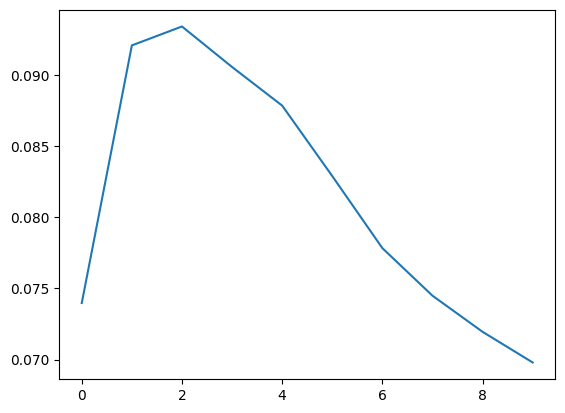

In [21]:
import matplotlib.pyplot as plt

plt.plot(history)
plt.show()